In [6]:
import numpy as np
import matplotlib.pyplot as plt
t_w=100
import os
import chaospy as cp
from FHNCUDAlib import FHNCUDA

nc=12

def plota(data,T):
    print(np.shape(data))
    # Create a meshgrid for X and Y values
    x = np.linspace(0, 50, np.shape(data)[1])
    y = np.linspace(0, 12, np.shape(data)[0])
    X, Y = np.meshgrid(x, y)

    # Create a figure and 3D Axes objects for subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})

    # Plot the surface color plots on each subplot
    surfs = []
    data_arrays = [data, data]
    plot_titles = ['Data', 'Data']
    mi,ma=0,1
    #print(data)
    for i, ax in enumerate(axs):
        if(i==2):
            ax.set_zlim(0,0.1) 
            mi,ma=0,0.1
        
        surf = ax.plot_surface(X, Y, data, cmap='viridis',vmin=mi,vmax=ma)
        surfs.append(surf)
        ax.set_title(plot_titles[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Value')
        fig.colorbar(surf, ax=ax)
        if(i==2):
            ax.set_zlim(0,0.6) 
    # Show the multi-plot
    plt.tight_layout()
    plt.show()

def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol
def unique(array):
        uniq, index = np.unique(array, return_index=True)
        return uniq[index.argsort()]
def getDatasetFromDistA(sample_set, data_folder="./extrapol/",ti=0,tf=50):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)

    V = np.empty(0)
    U = np.empty(0)
    print("Generating dataset in",data_folder)



    deltaT = 0.01
    rate =50
    num_samples= np.shape((sample_set))[1]
    # Generate Latin Hypercube Samples
    print(np.shape(sample_set))
    u,v ,t,p=FHNCUDA.run(sample_set.T,tf,deltaT,rate)
    SOLs=np.array(u).flatten()
    SOLw=np.array(v).flatten()
    t=t[0]
    T =np.tile(t,num_samples)

    
    K= np.repeat(unique(sample_set[2,:]),len(t))
    
  
    U =np.repeat(unique(sample_set[0,:]),len(t))
    V =np.repeat(unique(sample_set[1,:]),len(t))
    
    
    



    print("Generated_set")
    plt.plot(SOLs[0:1*int((tf-ti)//(deltaT*rate))])
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
    nc=num_samples
    pred_u= np.reshape(SOLs, (nc,len(t)))
    true_u= np.reshape(SOLs, (nc,len(t)))
    plota(pred_u,T)
    



In [3]:
# Define the ranges
krange = [0.08, 0.12]
vrange = [0.0, 0.12]
urange = [0.0, 0.8]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)
    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=2E5
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)
sample_set=sample_set.T



import copy
print(sample_set)

print("Gerando validaçao")
getDatasetFromDistA(sample_set[:,0:int(T*0.1)],data_folder="./validation/",ti=0,tf=50)

print("Gerando treino 1")
getDatasetFromDistA(sample_set[:,int(T*0.1):],data_folder="./treino1/",ti=0,tf=50)

Gerando treino 3
overweriting
Generating dataset in ./treino3/
(3, 200000)
kernel call: ./a.out 50 0.01 50
36
Number of rows in the CSV file:  200000 100
Generated_set


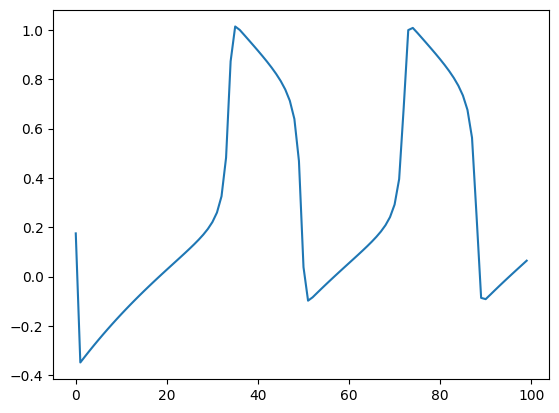

(200000, 100)


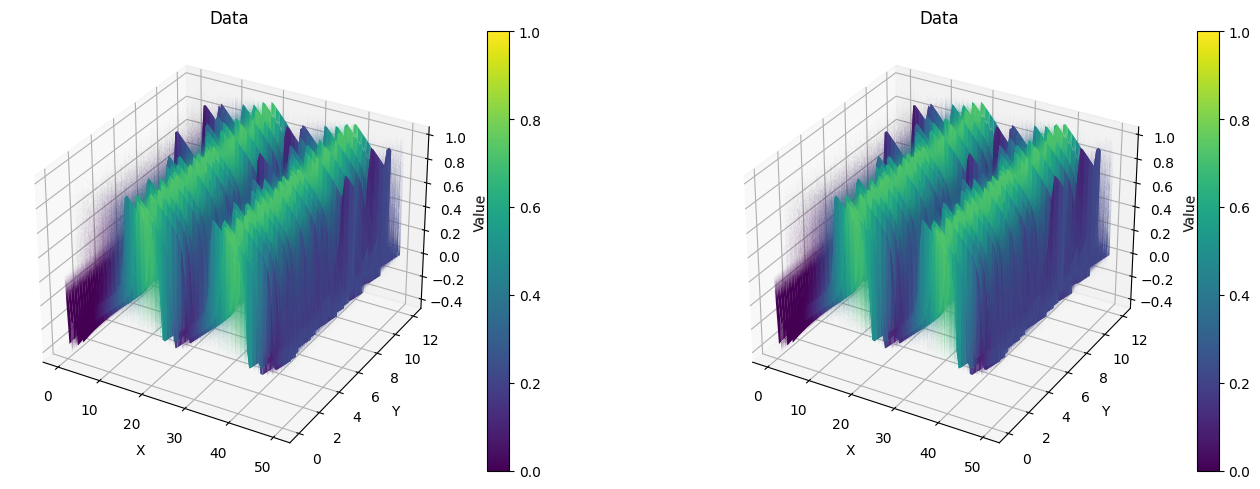

In [30]:
# Define the ranges
krange = [0.088, 0.089]
vrange = [0.04, 0.7]
urange = [0., 0.34]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)
    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=2e5
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)
sample_set=sample_set.T


#0.08946272730827332 0.24604074656963348 0.0607614889740943
import copy
print("Gerando treino 3")
getDatasetFromDistA(sample_set,data_folder="./treino3/",ti=0,tf=50)

In [ ]:
def specialConstrain(sample_set, data_folder="./treino2/"):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)
    SOLs = np.empty(0)
    SOLw = np.empty(0)
    U= np.empty(0)
    
    V = np.empty(0)
    deltaT = 0.01
    rate = 25
    t_max=50
    Nr=10
    for sample in sample_set.T:
        u,v,iap=sample
        for i in range (Nr):
                    begin=0
                    sol=generateExactSolution(t_max,deltaT,u,v,rate,iap,0,t_max)

                    T=np.append(T,sol.T[2] - begin)
                    K = np.append(K,np.full_like (sol.T[2],iap))
                    U = np.append(U,np.full_like (sol.T[2],u))

                    V= np.append(V,np.full_like(sol.T[2],v))

                    SOLs=np.append(SOLs,sol.T[0])
                    SOLw=np.append(SOLw,sol.T[1])
                    u,v=SOLs[-1],SOLw[-1]
     

    print(np.shape(SOLs))
    plt.plot(SOLs[0:2000])
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)

# Define the ranges
krange = [0.08, 0.12]
vrange = [0.0, 0.12]
urange = [0.0, 0.1]
# Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)
    
joint_dist = cp.J(u_dist,v_dist,k_dist)
sample_set = joint_dist.sample(6e4, rule="L")



import copy
specialConstrain(sample_set,data_folder="./treino2/")

overweriting


In [12]:
import numpy as np

# Example array
arr = np.array([5,3, 1, 2, 3, 1, 2, 4])
unique(arr)

NameError: name 'unique' is not defined